In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# 관련 모듈 부르기 및 시각화를 위한 셋팅
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scikitplot as skplt

from graphviz import Source
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
from sklearn import datasets, metrics, model_selection, svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score,recall_score, precision_score
from sklearn.metrics import confusion_matrix, roc_curve,f1_score, auc
from sklearn.metrics import classification_report,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
sns.set()
sns.set_style('white')
sns.set_color_codes(palette='dark') 


In [2]:
# 데이터 불러오기

data = pd.read_csv('.\p2p_data.csv')

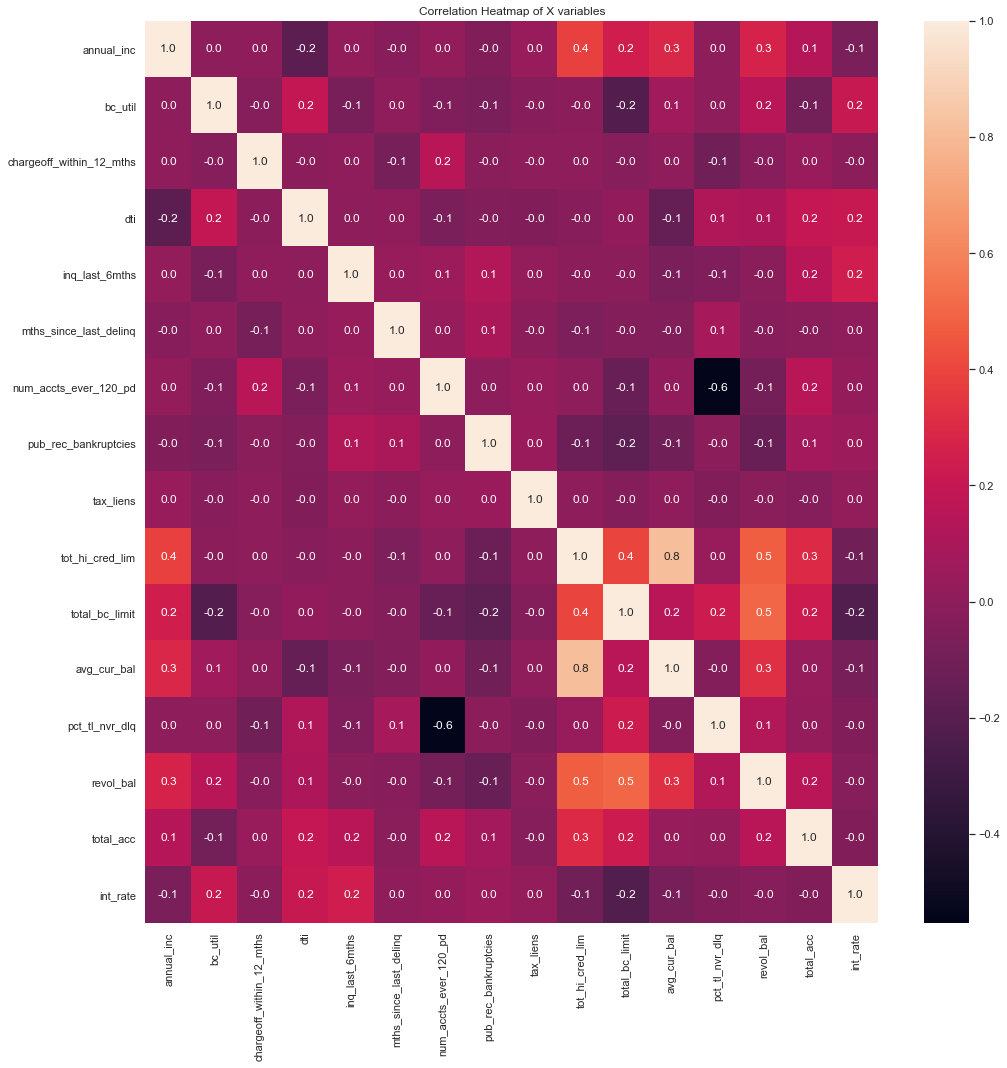

In [3]:
#변수간 Correlation 확인
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
ax = sns.heatmap(data.drop(['TARGET'], axis=1).corr(), annot=True, fmt='.1f')
ax.set_title("Correlation Heatmap of X variables")
plt.tight_layout()
plt.show(fig)

In [4]:
data=data.drop(['verification_status','home_ownership','term'],axis=1)

In [5]:
#X변수와 Y변수 분리
#TARGET이 Y고 나머지가 X
y=data['TARGET'].values
X=data.drop('TARGET',axis=1)

In [6]:
#train data와 test data로 분할
X_train, X_test, y_train, y_test=train_test_split(X, y,
                                                 stratify=y,
                                                 test_size=0.2,
                                                 random_state=93456)

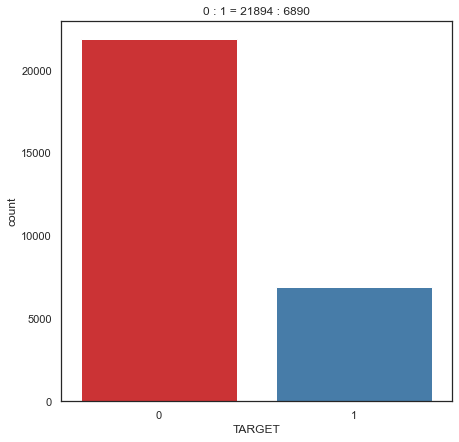

In [7]:
#0: 상환 성공 1: 상환 실패 
#0: 21894
#1: 6890
# 전체적으로 상환 실패가 더 적다
data['TARGET'].value_counts()


# Check class label distribution
#좀 중요하게 이야기했던 게 상환 여부를 분류하는 클래스 문제인데
#여기서는 중요한 게 클래스의 비율을 살펴봐야 한다고 했었다.
#상환 실패가 이렇게 클래스가 적기 때문에 상환 실패를 잘 분류하기 위해서 
#애를 쓰지 않을까 생각한다.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
sns.countplot(data['TARGET'], palette='Set1', ax=ax)
ax.set_title("0 : 1 = {} : {}".format(*data['TARGET'].value_counts()))
plt.show()

In [8]:
#validation set 분리
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size=1/9,
                                                      stratify=y_train,
                                                      random_state=93456)

In [9]:
#이 패키지에 대해서 살펴보자. DTR을 살펴보면 옵션이 여러 개가 있다
#기본적으로 criterion이 있다. 여기선 거의다 디폴트 값으로 두겠다. 

tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
y_tree = tree.predict(X_test)

In [10]:
treeBagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(),
                               n_estimators=100)
#피팅을 한다
treeBagging.fit(X_train, y_train)
#테스트 데이터를 예측해서 이것을 y_treeBagging이라 명명한다.
y_treeBagging = treeBagging.predict(X_test)

In [11]:
#하나 더 비교해 본다.
lr = LinearRegression()
lr.fit(X_train, y_train)
#테스트 데이터를 예측해본다.
y_lr = lr.predict(X_test)

In [12]:
#이것은 linear regression으로 했으니까 lrBagging이라고 해본다. 
lrBagging = BaggingRegressor(base_estimator=LinearRegression(),
                             n_estimators=100)
lrBagging.fit(X_train, y_train)
#테스트 데이터를 예측한다.
y_lrBagging = lrBagging.predict(X_test)

In [13]:
#위에서 한 4가지를 평가해본다. 
mse_tree = mean_squared_error(y_test, y_tree)
mse_treeBagging = mean_squared_error(y_test, y_treeBagging)
mse_lr = mean_squared_error(y_test, y_lr)
mse_lrBagging = mean_squared_error(y_test, y_lrBagging)

r2_tree = r2_score(y_test, y_tree)
r2_treeBagging = r2_score(y_test, y_treeBagging)
r2_lr = r2_score(y_test, y_lr)
r2_lrBagging = r2_score(y_test, y_lrBagging)

In [14]:
#지금 보면 4가지가 나오는데 각각 별로 R^2와 MSE를 구했다 vanila는 기본 트리
#그리고 배깅을 이용한 트리 이렇게 나뉜다. 
#트리부터 살펴보자. 기본트리의 R-squared는 0.65 정도 된다
#근데 배깅을 이용하니까 R^2가 0.2정도 올라간다. 그리고 MSE도 많이 줄어들었다.
#기본 트리보다 배깅을 이용했을 때가 퍼포먼스가 좋았다
#선형회귀를 살펴보자. 
#배깅을 이용해서 봤을 때 크게 달라지지 않았다.
#왜그럴까요?
#왜냐면 이 앙상블을 배웠는데 앙상블은 두가지 목적이 있다 varinace 감소 목적과 bias
#감소목적이 있는데 여기선 배깅을 쓰는데 즉 variance를 감소하는 것이다
#variance는 모델이 복잡할 때 생긴다. 근데 여기 우리가 모델을 학습할 때
#DT를 학습할 떄 우리가 디폴트 옵션으로 학습했는데 디폴트가 max_depth가 none이다
#즉 디폴트일 때 fully grown가 되니까 복잡한 모델이 생기게 되는 것이다
#거기서 오버피팅이 발생하는데 이것을 어떻게 보면 배깅을 통해서 줄여준 것이다
#선형회귀는 모델 자체가 단순해서 variance 에러가 크지 않다
#그래서 배깅을 하더라도 크게 달라지지 않는다. 
print('[Tree   - vanila ] R-square = {:.2f} | MSE = {:.2f}'.format(r2_tree, mse_tree))
print('[Tree   - Bagging] R-square = {:.2f} | MSE = {:.2f}'.format(r2_treeBagging, mse_treeBagging))
print('[Linear - vanila ] R-square = {:.2f} | MSE = {:.2f}'.format(r2_lr, mse_lr))
print('[Linear - Bagging] R-square = {:.2f} | MSE = {:.2f}'.format(r2_lrBagging, mse_lrBagging))

[Tree   - vanila ] R-square = -0.80 | MSE = 0.33
[Tree   - Bagging] R-square = 0.07 | MSE = 0.17
[Linear - vanila ] R-square = 0.10 | MSE = 0.16
[Linear - Bagging] R-square = 0.10 | MSE = 0.16


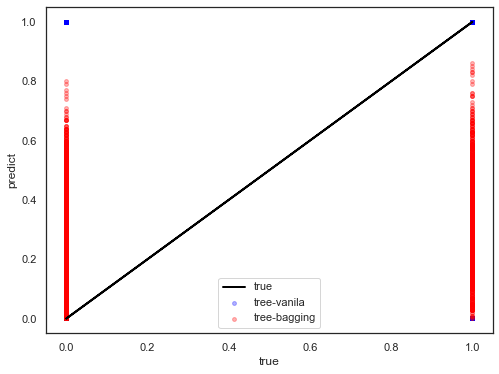

In [15]:
#시각화를 해보자.
#이 검정색 직선은 이 직선에 가까우면 가까울수록 좋은 결과이다.
#vanila tree를 보면 이 직선에 비교했을 떄 분산이 크다
#반면에 배깅을 했을 땐 근처에 있어서 분산이 줄어든 거을 볼 수 있다.
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_tree, s=15, alpha=0.3, color='blue', label='tree-vanila')
plt.scatter(y_test, y_treeBagging, s=15, alpha=0.3, color='red', label='tree-bagging')
plt.plot(y_test, y_test, alpha=1.0, lw=2, color='black', label='true')
plt.xlabel('true', fontsize=12)
plt.ylabel('predict', fontsize=12)
plt.legend()
plt.show()

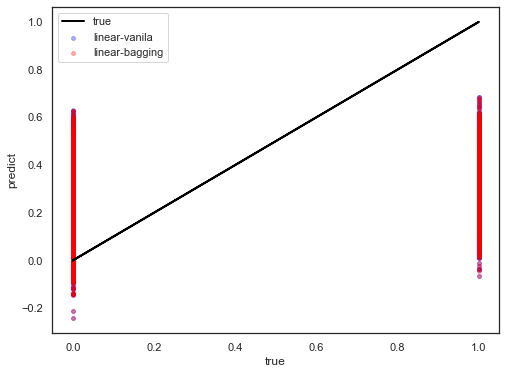

In [16]:
#여기서는 LR의 결과이ㅣ다
#지금 보면 아예 똑같다. 거의 차이가 없다는 것이다 완전히 겹쳐져 있다.
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_lr, s=15, alpha=0.3, color='blue', label='linear-vanila')
plt.scatter(y_test, y_lrBagging, s=15, alpha=0.3, color='red', label='linear-bagging')
plt.plot(y_test, y_test, alpha=1.0, lw=2, color='black', label='true')
plt.xlabel('true', fontsize=12)
plt.ylabel('predict', fontsize=12)
plt.legend()
plt.show()

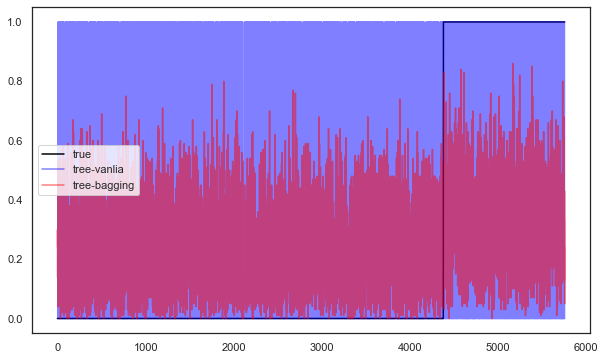

In [17]:
idx = y_test.argsort()

plt.figure(figsize=(10, 6))
plt.plot(y_test[idx], color='black', alpha=1.0, label='true')
plt.plot(y_tree[idx], color='blue', alpha=0.5, label='tree-vanlia')
plt.plot(y_treeBagging[idx], color='red', alpha=0.5, label='tree-bagging')
plt.legend()
plt.show()

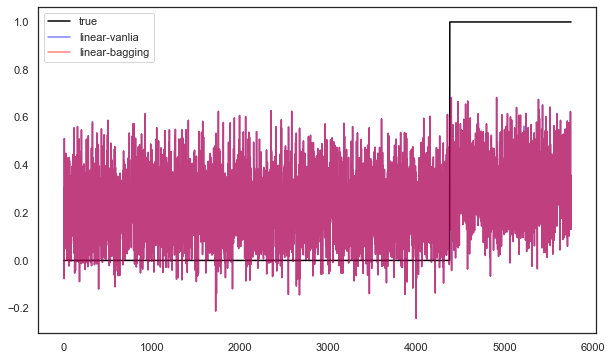

In [18]:

plt.figure(figsize=(10, 6))
plt.plot(y_test[idx], color='black', alpha=1.0, label='true')
plt.plot(y_lr[idx], color='blue', alpha=0.5, label='linear-vanlia')
plt.plot(y_lrBagging[idx], color='red', alpha=0.5, label='linear-bagging')
plt.legend()
plt.show()